In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

import tensorflow as tf

%matplotlib inline

## The Data
The data and documentation is available at: https://data.ny.gov/Transportation/Turnstile-Usage-Data-2018/bjcb-yee3

There is an associated API, but there are over $10$ million rows so I decided to just work with it locally

In [2]:
turnstile_df = pd.read_csv('Turnstile_Usage_Data__2018.csv')

In [3]:
turnstile_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,2056268,5177036
1,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,70294362,20274025
2,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,14197229,13704110
3,A033,R170,02-00-01,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,1806541,2182381
4,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,15598097,6250334


Let's index the DataFrame by the date and time

In [4]:
turnstile_df['Date_time'] = pd.to_datetime(turnstile_df['Date'] + ' ' +
                                           turnstile_df['Time'], format="%m/%d/%Y %H:%M:%S")
turnstile_df.set_index('Date_time', inplace=True)
turnstile_df = turnstile_df.drop(['Date', 'Time'], axis=1)

In [5]:
turnstile_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Description,Entries,Exits
Date_time,,,,,,,,,
2018-12-28,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,REGULAR,2056268,5177036
2018-12-28,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,REGULAR,70294362,20274025
2018-12-28,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,REGULAR,14197229,13704110
2018-12-28,A033,R170,02-00-01,14 ST-UNION SQ,LNQR456W,BMT,REGULAR,1806541,2182381
2018-12-28,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,REGULAR,15598097,6250334


In [6]:
turnstile_df.sort_values(['C/A','Unit','SCP', 'Date_time'], inplace=True);

In [7]:
turnstile_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Description,Entries,Exits
Date_time,,,,,,,,,
2017-12-23 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6455840,2184987
2017-12-23 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6455856,2184995
2017-12-23 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6455899,2185082
2017-12-23 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6456038,2185156
2017-12-23 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6456327,2185197


The assumption is that this dataset for $2018$ turnstile activity, so let's filter out the $2017$ entries

In [8]:
turnstile_df = turnstile_df[turnstile_df.index >= '2018-01-01']

In [9]:
turnstile_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Description,Entries,Exits
Date_time,,,,,,,,,
2018-01-01 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6464475,2188055
2018-01-01 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6464491,2188064
2018-01-01 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6464517,2188106
2018-01-01 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6464623,2188146
2018-01-01 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6464806,2188192


Hardware malfunctions and troubleshooting affect the data collection. I choose to take only the audit events labeled as *Regular*; this of course may underestimate the number of entries/exits through a turnstile.

In [10]:
# Take only 'REGULAR' events from data
turnstile_df = turnstile_df[turnstile_df['Description'] == 'REGULAR']

Each *Entries*/*Exits* cell is a cumulative register, so to get the absolute numbers at a given time stamp we do a simple subtraction. The groupby is done in that order to uniquely identify turnstiles.

In [11]:
turnstile_df['Absolute Entries'] = turnstile_df.groupby(
    ['C/A', 'Unit', 'SCP'])['Entries'].apply(lambda entries: entries - entries.shift(1)).fillna(0)
turnstile_df['Absolute Exits'] = turnstile_df.groupby(
    ['C/A', 'Unit', 'SCP'])['Exits'].apply(lambda exits: exits - exits.shift(1)).fillna(0)

In [12]:
print('Maximum Number of Entries:', turnstile_df['Absolute Entries'].max(), 'Minimum NUmber of Entries:', turnstile_df['Absolute Entries'].min())

Maximum Number of Entries: 2105700124.0 Minimum NUmber of Entries: -2113959893.0


The dataset has got some negative values (what is a negative entry or a negative exit?) or values that are unreasonably high; but how can we quantify "unreasonably high"? Let’s make some crude assumptions:

Most time stamps are separated by $4$ hours (some by smaller intervals) and there are $4 \cdot 60\mathrm{min} \cdot 60\mathrm{s} = 14400\mathrm{s}$ in $4$ hours.

Let’s assume that each pass through a turnstile takes $1$ second, then there cannot be more than $14400$ counts in any entry or exit cell, some New Yorkers speed through the turnstiles, so let’s make the cutoff be $15000$.

We'll group by month and turnstile and replace the negatives and the large cells with the median for the month for the turnstile.

In [13]:
def replace(traffic):
    mask = ((traffic >= 0) & (traffic <= 15000))
    return traffic.where(mask, traffic[mask].median())

In [14]:
# replace negative entries and entries greater than 15000 with median for month
turnstile_df['Absolute Entries'] = turnstile_df.groupby(
    ['SCP', 'Unit', turnstile_df.index.month])['Absolute Entries'].transform(replace)
turnstile_df['Absolute Exits'] = turnstile_df.groupby(
    ['SCP', 'Unit', turnstile_df.index.month])['Absolute Exits'].transform(replace)

Let's define the *Traffic* of a given station by the sum of the *Absolute Entries* and *Absolute Exits* 

In [15]:
turnstile_df['Absolute Traffic'] = turnstile_df['Absolute Entries'] + turnstile_df['Absolute Exits']

## Let's try and do some forecasting!

Let's begin by looking at the daily traffic on the subway

In [16]:
turnstile_date = turnstile_df.groupby(turnstile_df.index.date).sum()
turnstile_date.index = pd.to_datetime(turnstile_date.index)
turnstile_date = turnstile_date.drop(['Entries', 'Exits', 'Absolute Entries', 'Absolute Exits'], axis=1)
turnstile_date.head()

,Absolute Traffic
2018-01-01,3160230.0
2018-01-02,8831135.0
2018-01-03,9779809.0
2018-01-04,5505269.0
2018-01-05,8403859.5


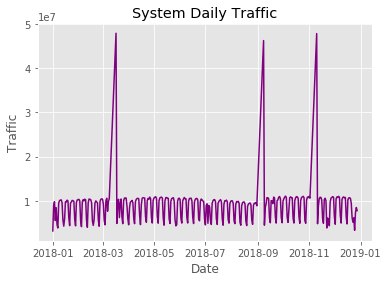

In [17]:
plt.plot(turnstile_date, c = 'purple')
plt.title('System Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Traffic')

The data looks relatively periodic but there are three very sudden spikes.
March 17<sup>th</sup> is St. Patrick's Day, which is a pretty active holiday in NYC, we can see similar spikes in the turnstile data from previous years, however I'm skeptical of nearly $4\times10^7$ spike.

As for the other dates; I did some quick googling and found the Labor Day Parade (Not to be confused with J'Ouvert) and a Billy Joel Concert, but neither of these alone could cause such a massive increase.

Let’s replace these spikes with the median value of their month’s to make our analysis easier

In [18]:
turnstile_date[turnstile_date['Absolute Traffic'] > 2e7]

,Absolute Traffic
2018-03-17,47957842.0
2018-09-08,46298128.5
2018-11-10,47885345.0


In [19]:
def replace_med(traffic):
    mask = traffic < 2e7
    return traffic.where(mask, traffic[mask].median())

In [20]:
turnstile_date['Absolute Traffic'] = turnstile_date.groupby(turnstile_date.index.month)['Absolute Traffic'].transform(replace_med);

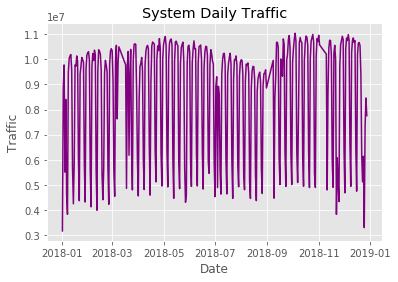

In [21]:
plt.plot(turnstile_date.index,turnstile_date['Absolute Traffic'], c='purple')
plt.title('System Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Traffic')

Now that we have wrangled the data a bit more, lets create our data set for a supervised machine learning model. We'll begin by adding columns lagged observations; 6 days.

In [22]:
turnstile_ml = pd.DataFrame(turnstile_date['Absolute Traffic'].copy())

In [23]:
for i in range(1, 7):
    turnstile_ml["{}_traffic_lag".format(i)] = turnstile_ml['Absolute Traffic'].shift(i)

There are some NaNs at the beginning of the dataset (because of the lags), we'll drop them upon training. 

In [24]:
turnstile_ml.dropna().head(7)

,Absolute Traffic,1_traffic_lag,2_traffic_lag,3_traffic_lag,4_traffic_lag,5_traffic_lag,6_traffic_lag
2018-01-07,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0,8831135.0,3160230.0
2018-01-08,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0,8831135.0
2018-01-09,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0
2018-01-10,10139457.5,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0
2018-01-11,10193285.0,10139457.5,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5
2018-01-12,9573263.0,10193285.0,10139457.5,10032275.0,9469963.5,3821369.5,4618326.0
2018-01-13,5648697.0,9573263.0,10193285.0,10139457.5,10032275.0,9469963.5,3821369.5


In [25]:
def plot_results(model, data, x_test):
    test_predict = scalery.inverse_transform(model.predict(x_test))
    error = mean_absolute_error(data.values[-len(x_test):], test_predict)
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(data.index[-len(x_test):], test_predict, c='g', label='Predicted Data (Mean Absolute Error: {0:.2f})'.format(error))
    ax.plot(data.index[-len(x_test):], data.values[-len(x_test):], c='purple', label='Measured Data')

    fig.autofmt_xdate()
    ax.legend()
    plt.show()

In [26]:
def train_test_split(x, y, test_size):
    
    test_index = int((1 - test_size) * len(x))

    x_train = x.iloc[:test_index]
    y_train = y.iloc[:test_index]
    x_test = x.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return x_train, y_train, x_test, y_test

Let's see how a vanilla least squares does on this data

In [27]:
x_train, y_train, x_test, y_test = train_test_split(
    turnstile_ml.dropna().iloc[:, 1:],
    turnstile_ml.dropna()['Absolute Traffic'],
    test_size=0.1)

lr = LinearRegression()
lr.fit(x_train, y_train)

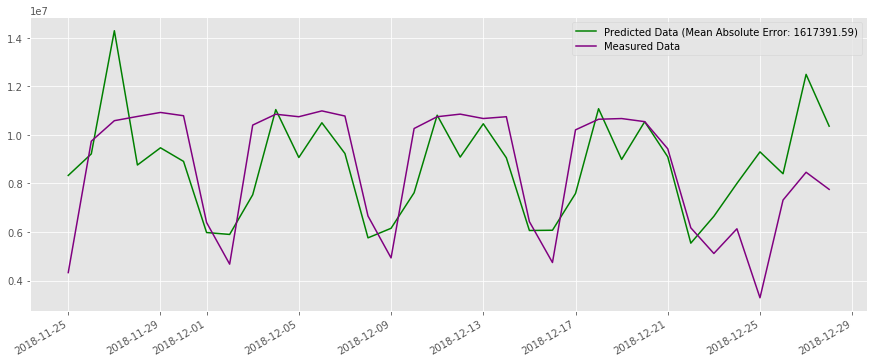

In [28]:
test_predict = lr.predict(x_test)
error = mean_absolute_error(y_test, test_predict)
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(turnstile_ml.index[-len(x_test):], test_predict, c='g', label='Predicted Data (Mean Absolute Error: {0:.2f})'.format(error))
ax.plot(turnstile_ml.index[-len(x_test):], y_test, c='purple', label='Measured Data')

fig.autofmt_xdate()
ax.legend()
plt.show()

The model was able to capture the periodicity, but we could probably improve it.

Let's try adding some extra information like weekday, weekend (Boolean), and average weekday traffic.

In [29]:
turnstile_ml["weekday"] = turnstile_ml.index.weekday
turnstile_ml['is_weekend'] = 1 * turnstile_ml.weekday.isin([5, 6])
turnstile_ml['avg_weekday'] = turnstile_ml.groupby('weekday')['Absolute Traffic'].transform('mean')

In [30]:
turnstile_ml.dropna().head()

,Absolute Traffic,1_traffic_lag,2_traffic_lag,3_traffic_lag,4_traffic_lag,5_traffic_lag,6_traffic_lag,weekday,is_weekend,avg_weekday
2018-01-07,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0,8831135.0,3160230.0,6,1,4.678271e+06
2018-01-08,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0,8831135.0,0,0,9.119029e+06
2018-01-09,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0,9779809.0,1,0,1.004843e+07
2018-01-10,10139457.5,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5,5505269.0,2,0,1.003155e+07
2018-01-11,10193285.0,10139457.5,10032275.0,9469963.5,3821369.5,4618326.0,8403859.5,3,0,1.010645e+07


ML algorithms tend to work better when the values are scaled, so let’s do that too.

In [31]:
scalerx = StandardScaler()
scalery = StandardScaler()

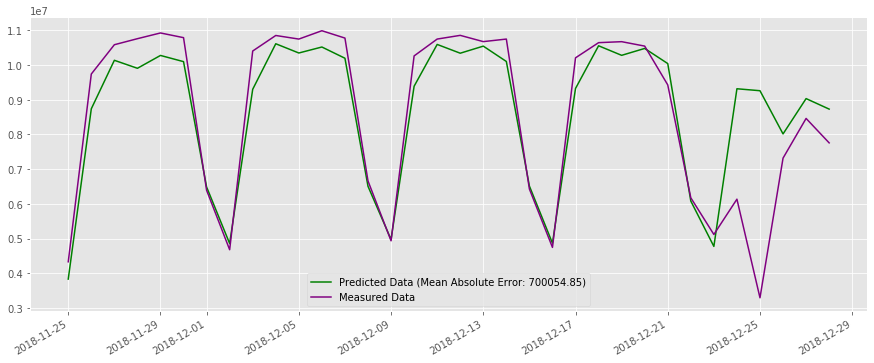

In [32]:
x_train, y_train, x_test, y_test = train_test_split(
    turnstile_ml.dropna().iloc[:, 1:],
    turnstile_ml.dropna()['Absolute Traffic'],
    test_size=0.1)

x_train_scaled = scalerx.fit_transform(x_train)
x_test_scaled = scalerx.transform(x_test)

y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scalery.transform(y_test.values.reshape(-1,1))


lr = LinearRegression()
lr.fit(x_train_scaled, y_train_scaled)

plot_results(lr, turnstile_ml.dropna()['Absolute Traffic'], x_test= x_test_scaled)

So, we've done *much* better. The error is around two orders of magnitude the scale of the data. The extra features definitely helped, let’s try boosting and see how we do.

In [33]:
xgb = XGBRegressor()
xgb.fit(x_train_scaled, y_train_scaled)

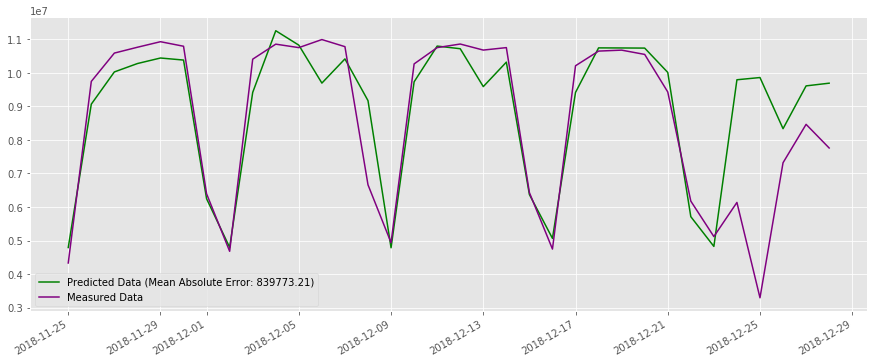

In [34]:
plot_results(xgb, turnstile_ml.dropna()['Absolute Traffic'], x_test= x_test_scaled)

Not terrible, but not an improvement. Lesson here: don't boost blindly

Let's try an LSTM. This could be very prone to overfitting, so I'll add some early stopping and use $10\%$ of the training data for validation.

In [35]:
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.LSTM(128, input_shape=(1, x_train.shape[1])))
rnn_model.add(tf.keras.layers.Dense(1))
rnn_model.compile(loss='mae', optimizer='adam')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

rnn_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[1]),
                    y_train_scaled,
                    epochs=300, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop], verbose=0, shuffle=False)

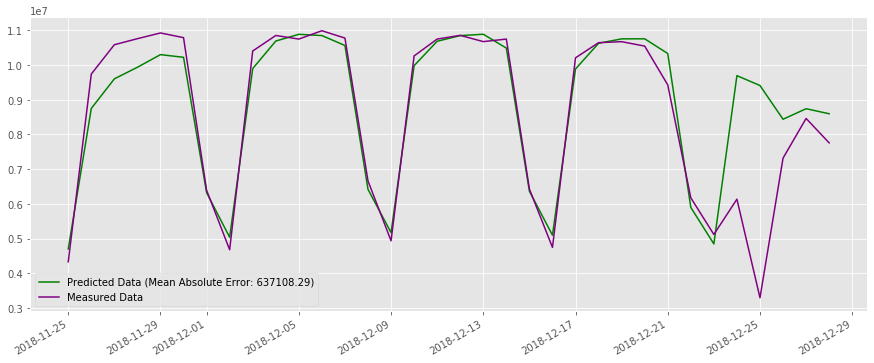

In [36]:
plot_results(rnn_model, turnstile_ml.dropna()['Absolute Traffic'], x_test= x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

Okay, so by far the best result, but due to the random initialization of RNN, we need to calculate some uncertainties in order to really evaluate how well it performs.

I ran the network $100$ times and saved it to a file also contained in this repository.

In [37]:
rnn_preds = np.loadtxt('rnn.txt')
rnn_preds_scaled = scalery.inverse_transform(rnn_preds)

In [38]:
mean = np.mean(rnn_preds_scaled , axis=0)
std = np.std(rnn_preds_scaled , axis=0)

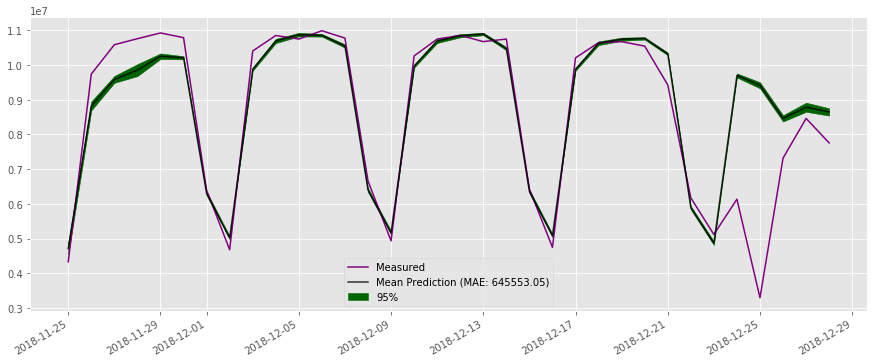

In [39]:
fig, ax = plt.subplots(figsize=(15,6))
error = mean_absolute_error(y_test.values, mean)
ax.plot(turnstile_ml.index[-len(mean):], y_test.values, c = 'purple', label='Measured')
ax.plot(turnstile_ml.index[-len(mean):], mean, label='Mean Prediction (MAE: {0:.2f})'.format(error), c='black', alpha = 0.8)
ax.fill_between(turnstile_ml.index[-len(mean):], mean-2*std, mean+2*std, label='95%', color='darkgreen')

fig.autofmt_xdate()
ax.legend()
plt.show()

So I have plotted the mean and filled in the $95\%$ predictive interval. For the most part, it does well, the biggest deviation from the true value is around Christmas. Since the model was trained on pretty regular subway usage patters, it makes sense that it over predicts the traffic during the holiday that NYC is at its calmest.